Copyright 2021 The TensorFlow Similarity Authors.

In [16]:
#@title Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#
# https://www.apache.org/licenses/LICENSE-2.0
#
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.

In [17]:
from collections import defaultdict
import gc
import os

import numpy as np

In [18]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import SGD

In [19]:
# install TF similarity if needed
try:
    import tensorflow_similarity as tfsim  # main package
except:
    !pip install tensorflow_similarity
    import tensorflow_similarity as tfsim

In [20]:
from tensorflow_similarity.samplers import SingleShotMemorySampler
from tensorflow_similarity.augmenters import SimCLRAugmenter
from tensorflow_similarity.models import ContrastiveModel
from tensorflow_similarity.losses import SimSiamLoss
from tensorflow_similarity.losses import SimCLRLoss
from tensorflow_similarity.training_metrics import encoder_std  ## siam siam metric
from tensorflow_similarity.visualization import visualize_views

In [21]:
tfsim.utils.tf_cap_memory() # Avoid GPU memory blow up

In [22]:
tf.keras.backend.clear_session() 
gc.collect()

316

# Dataset

## Loading

In [23]:
(x_train, y_raw_train), (x_test, y_raw_test) = keras.datasets.cifar100.load_data()
print("x_train", x_train.shape, "x_test", x_test.shape)
y_train = keras.utils.to_categorical(y_raw_train, 100)
y_test = keras.utils.to_categorical(y_raw_test, 100)
print("y_train", y_train.shape, "y_test", y_test.shape)

x_train (50000, 32, 32, 3) x_test (10000, 32, 32, 3)
y_train (50000, 100) y_test (10000, 100)


In [47]:
IMG_SIZE = 32
PRE_TRAIN_IMGS = 512
TRAIN_BATCH_SIZE = 512
STEPS_PER_EPOCH = len(x_train) // PRE_TRAIN_IMGS

In [48]:
train_augmenter = SimCLRAugmenter(IMG_SIZE, IMG_SIZE, is_training=True)
#     #test_augmenter = SimCLRAugmenter(IMG_SIZE,IMG_SIZE, is_training=False)
sampler = SingleShotMemorySampler(x_train, examples_per_batch=PRE_TRAIN_IMGS, steps_per_epoch=STEPS_PER_EPOCH, augmenter=train_augmenter, num_augmentations_per_example=2)


The initial batch size is 512 (512 classes * 1 examples per class) with 2 augmenters


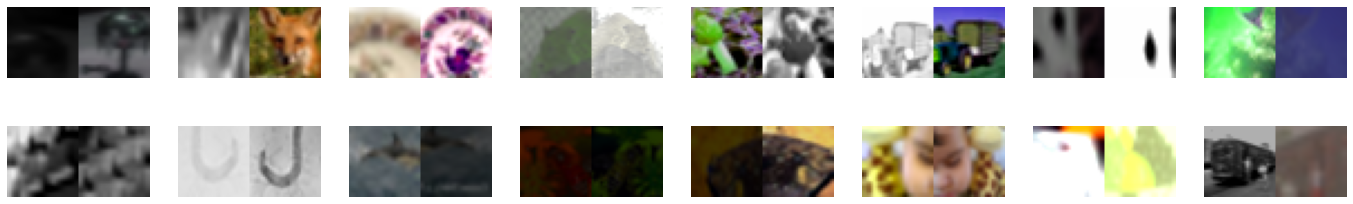

In [49]:
views = sampler.generate_batch(0)

visualize_views(views=views, num_imgs=16, views_per_col=8)

# Models

## Backbone 

In [50]:
def get_encoder(IMG_SIZE, dim=2048, activation='relu', trainable=True):
    base_model = tf.keras.applications.ResNet50V2(include_top=False,
        weights=None, input_shape=(IMG_SIZE, IMG_SIZE, 3))
    base_model.trainable = trainable

    inputs = layers.Input((IMG_SIZE, IMG_SIZE, 3))
    # ResNet expects [-1,1], but our augmented images are [0,1]
    x = layers.Rescaling(scale=2, offset=-1)(inputs)
    x = base_model(x, training=True)
    x = layers.GlobalAveragePooling2D(name="backbone_pool")(x)
    
    # Projection Head
    x = layers.Dense(dim, use_bias=False)(x)
    x = layers.BatchNormalization()(x)
    x = layers.Activation(activation=activation)(x)
    
    x = layers.Dense(dim, use_bias=False)(x)
    x = layers.BatchNormalization()(x)
    x = layers.Activation(activation=activation)(x)
    
    x = layers.Dense(dim, use_bias=False)(x)
    o = layers.BatchNormalization()(x)

    backbone = Model(inputs, o, name='encoder')
    return backbone

encoder = get_encoder(IMG_SIZE)
encoder.summary()

Model: "encoder"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_13 (InputLayer)        [(None, 32, 32, 3)]       0         
_________________________________________________________________
rescaling_3 (Rescaling)      (None, 32, 32, 3)         0         
_________________________________________________________________
resnet50v2 (Functional)      (None, 1, 1, 2048)        23564800  
_________________________________________________________________
backbone_pool (GlobalAverage (None, 2048)              0         
_________________________________________________________________
dense_19 (Dense)             (None, 2048)              4194304   
_________________________________________________________________
batch_normalization_16 (Batc (None, 2048)              8192      
_________________________________________________________________
activation_12 (Activation)   (None, 2048)              0   

## Predictor model

In [51]:
def get_predictor(dim, hiddin_dim=512, activation='relu'):
    inputs = layers.Input(shape=(dim,))
    
    x = layers.Dense(dim, use_bias=False)(inputs)
    x = layers.BatchNormalization()(x)
    x = layers.Activation(activation=activation)(x)
    
    x = layers.Dense(hiddin_dim, use_bias=False)(x)
    x = layers.BatchNormalization()(x)
    x = layers.Activation(activation=activation)(x)
    
    o = layers.Dense(dim)(x)
    projector = Model(inputs, o, name="predictor")
    return projector

predictor = get_predictor(2048)
predictor.summary()

Model: "predictor"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_14 (InputLayer)        [(None, 2048)]            0         
_________________________________________________________________
dense_22 (Dense)             (None, 2048)              4194304   
_________________________________________________________________
batch_normalization_19 (Batc (None, 2048)              8192      
_________________________________________________________________
activation_14 (Activation)   (None, 2048)              0         
_________________________________________________________________
dense_23 (Dense)             (None, 512)               1048576   
_________________________________________________________________
batch_normalization_20 (Batc (None, 512)               2048      
_________________________________________________________________
activation_15 (Activation)   (None, 512)               0 

# Loss

In [52]:
# This loss is minimizing either the cosine distance or the angular 
# distance and should be between [0, 4]
loss = SimSiamLoss
metrics = [[encoder_std], []]

# Pre Training

In [ ]:
PRE_TRAIN_EPOCHS = 100
contrastive_model = ContrastiveModel(encoder_model=encoder, 
                         projector_model=predictor, 
                         swap_representation=True)
# use sgd as optimizer with constant loss as recommende in the paper.
steps = PRE_TRAIN_EPOCHS * (len(x_train) // TRAIN_BATCH_SIZE)
lr_decayed_fn = tf.keras.optimizers.schedules.CosineDecay(
    initial_learning_rate=0.03, decay_steps=steps
)
sgd = tf.keras.optimizers.SGD(lr_decayed_fn, momentum=0.6)
contrastive_model.compile(optimizer=sgd, loss=loss, metrics=metrics)
contrastive_history = contrastive_model.fit(sampler, epochs=PRE_TRAIN_EPOCHS)

Epoch 1/100
97/97 [==============================] - 102s 996ms/step - loss: 1.6308 - output_1_encoder_std: 0.0221
Epoch 2/100
23/97 [======>.......................] - ETA: 1:14 - loss: 1.3865 - output_1_encoder_std: 0.0221

# Evaluation

In [54]:
TEST_EPOCHS = 20
LR = 0.03
from tensorflow_similarity.samplers import select_examples
# allows to use a fraction of the dataset via select_sample

x_restricted, y_restricted = select_examples(x_train, y_raw_train, num_examples_per_class=100)
y_restricted = keras.utils.to_categorical(y_restricted, 100)

filtering examples:   0%|          | 0/50000 [00:00<?, ?it/s]

selecting classes:   0%|          | 0/100 [00:00<?, ?it/s]

gather examples:   0%|          | 0/10000 [00:00<?, ?it/s]

In [55]:
def get_model(IMG_SIZE, decoder, LR, training):
    inputs = layers.Input((IMG_SIZE, IMG_SIZE, 3))
    x = encoder(inputs, training=training)
    o = layers.Dense(100, activation='softmax')(x)
    model = Model(inputs, o, name='no_pretrain')
    lr_decayed_fn = tf.keras.optimizers.schedules.CosineDecay(
        initial_learning_rate=LR, decay_steps=steps
    )
    sgd = tf.keras.optimizers.SGD(lr_decayed_fn, momentum=0.9)
    model.compile(optimizer=sgd, loss='categorical_crossentropy', metrics=['acc'])
    return model

# No pretrain

In [56]:
encoder = get_encoder(IMG_SIZE)
decoder = Model(
    encoder.input, encoder.get_layer("backbone_pool").output
)
decoder.trainable = False
reg_model = get_model(IMG_SIZE, decoder, LR, training=True)
reg_history = reg_model.fit(x_restricted, y_restricted, batch_size=TRAIN_BATCH_SIZE, epochs=TEST_EPOCHS, validation_data=(x_test, y_test))

Epoch 1/20
20/20 [==============================] - 5s 94ms/step - loss: 4.7253 - acc: 0.0601 - val_loss: 4.4084 - val_acc: 0.0790
Epoch 2/20
20/20 [==============================] - 1s 45ms/step - loss: 4.0489 - acc: 0.1154 - val_loss: 4.2484 - val_acc: 0.0978
Epoch 3/20
20/20 [==============================] - 1s 45ms/step - loss: 3.7002 - acc: 0.1717 - val_loss: 4.3896 - val_acc: 0.1006
Epoch 4/20
20/20 [==============================] - 1s 45ms/step - loss: 3.5376 - acc: 0.2025 - val_loss: 4.2528 - val_acc: 0.1143
Epoch 5/20
20/20 [==============================] - 1s 45ms/step - loss: 3.2988 - acc: 0.2321 - val_loss: 4.2123 - val_acc: 0.1175
Epoch 6/20
20/20 [==============================] - 1s 44ms/step - loss: 3.1308 - acc: 0.2607 - val_loss: 4.2195 - val_acc: 0.1243
Epoch 7/20
20/20 [==============================] - 1s 45ms/step - loss: 3.0398 - acc: 0.2789 - val_loss: 4.2316 - val_acc: 0.1303
Epoch 8/20
20/20 [==============================] - 1s 44ms/step - loss: 2.8864 - a

# Pretrained with SiamSiam

In [57]:
contrastive_model.projector.summary()

Model: "predictor"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_14 (InputLayer)        [(None, 2048)]            0         
_________________________________________________________________
dense_22 (Dense)             (None, 2048)              4194304   
_________________________________________________________________
batch_normalization_19 (Batc (None, 2048)              8192      
_________________________________________________________________
activation_14 (Activation)   (None, 2048)              0         
_________________________________________________________________
dense_23 (Dense)             (None, 512)               1048576   
_________________________________________________________________
batch_normalization_20 (Batc (None, 512)               2048      
_________________________________________________________________
activation_15 (Activation)   (None, 512)               0 

In [58]:
LR = 0.001
# encoder = contrastive_model.get_encoder()
# Extract the backbone ResNet20.
pt_encoder = Model(
    contrastive_model.encoder.input, contrastive_model.encoder.get_layer("backbone_pool").output
)
pt_encoder.trainable = False

model2 = get_model(IMG_SIZE, pt_encoder, LR, training=True)
model2.summary()

Model: "no_pretrain"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_18 (InputLayer)        [(None, 32, 32, 3)]       0         
_________________________________________________________________
encoder (Functional)         (None, 2048)              36172288  
_________________________________________________________________
dense_29 (Dense)             (None, 100)               204900    
Total params: 36,377,188
Trainable params: 12,800,100
Non-trainable params: 23,577,088
_________________________________________________________________


In [59]:
TEST_EPOCHS = 20

pre_history = model2.fit(x_restricted, y_restricted, batch_size=TRAIN_BATCH_SIZE, epochs=TEST_EPOCHS, validation_data=(x_test, y_test))

Epoch 1/20
20/20 [==============================] - 4s 91ms/step - loss: 4.9658 - acc: 0.0289 - val_loss: 4.5911 - val_acc: 0.0588
Epoch 2/20
20/20 [==============================] - 1s 44ms/step - loss: 4.0089 - acc: 0.1126 - val_loss: 4.1872 - val_acc: 0.0979
Epoch 3/20
20/20 [==============================] - 1s 45ms/step - loss: 3.4927 - acc: 0.1896 - val_loss: 4.0256 - val_acc: 0.1233
Epoch 4/20
20/20 [==============================] - 1s 44ms/step - loss: 3.1605 - acc: 0.2547 - val_loss: 3.9381 - val_acc: 0.1322
Epoch 5/20
20/20 [==============================] - 1s 44ms/step - loss: 2.9091 - acc: 0.3071 - val_loss: 3.8903 - val_acc: 0.1407
Epoch 6/20
20/20 [==============================] - 1s 44ms/step - loss: 2.7036 - acc: 0.3587 - val_loss: 3.8597 - val_acc: 0.1470
Epoch 7/20
20/20 [==============================] - 1s 45ms/step - loss: 2.5306 - acc: 0.4027 - val_loss: 3.8415 - val_acc: 0.1524
Epoch 8/20
20/20 [==============================] - 1s 44ms/step - loss: 2.3791 - a

In [60]:
print('no pretrain', reg_model.evaluate(x_test, y_test))
print('pretrained', model2.evaluate(x_test, y_test))

313/313 [==============================] - 3s 10ms/step - loss: 5.4267 - acc: 0.1384
no pretrain [5.426722526550293, 0.13840000331401825]
313/313 [==============================] - 3s 9ms/step - loss: 3.9204 - acc: 0.1541
pretrained [3.920355796813965, 0.15410000085830688]
